In [2]:
!pip3 install torch
!pip3 install torchvision

    100% |████████████████████████████████| 591.8MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61340000 @  0x7f4f4a8ec2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.6MB/s 
    100% |████████████████████████████████| 2.0MB 12.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler, SequentialSampler, Subset, ConcatDataset
from torchvision import transforms, utils


from collections import OrderedDict

import numpy as np

import time

In [0]:
from torchvision.datasets import MNIST, CIFAR10

In [7]:
cifar_dataset_train = CIFAR10("gdrive/My Drive/Datasets/CIFAR/", download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [8]:
cifar_dataset_test = CIFAR10("gdrive/My Drive/Datasets/CIFAR/", download=True, train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [0]:
MATCHING_SET_SIZE = 3
MAX_SAMPLES_PER_CLASS = -1
MAX_PULLS = 4000 #
BATCH_SIZE = 128

In [0]:
class SubsetAug(Subset):
    def __init__(self, *args, **kwargs):
        super(SubsetAug, self).__init__(*args, **kwargs)
     
    def __getitem__(self, indices):
        if type(indices) == int:
            return super(SubsetAug, self).__getitem__(indices)
        else:
            return [super(SubsetAug, self).__getitem__(index) for index in indices]

In [0]:
def construct_reduced_dataset(dataset, max_samples_per_class=20, required_classes=None):
    targets = np.array([target.numpy() if not type(target) == int else target for data,target in dataset])
    classes = set(targets) if required_classes is None else required_classes
    subset = []
    indices = np.arange(0, len(targets))

    for category in classes:
        category_indices = indices[targets==category]
        category_indices = np.random.permutation(category_indices)
        category_sample = category_indices[:max_samples_per_class] if max_samples_per_class != -1 else category_indices
        
        subset.extend(category_sample)
    
    data_subset = SubsetAug(dataset, subset)
    
    return data_subset, subset

In [0]:
cifar_data_subset, data_subset_indices = construct_reduced_dataset(cifar_dataset_train, max_samples_per_class=MAX_SAMPLES_PER_CLASS, required_classes=np.arange(0,5))

In [0]:
cifar_data_subset_all, data_subset_indices = construct_reduced_dataset(cifar_dataset_train, max_samples_per_class=1)

In [168]:
from joblib import dump, load
dump(cifar_data_subset, 'gdrive/My Drive/Datasets/CIFAR/subset_5c_100_5.joblib') 
dump(data_subset_indices, 'gdrive/My Drive/Datasets/CIFAR/subset_indices_5c_100_5.joblib') 

['gdrive/My Drive/Datasets/CIFAR/subset_indices_5c_100_5.joblib']

In [0]:
import random

class ClassSampler2(Sampler):
    def __init__(self, dataset, classes, matching_set_size, max_pulls=10000):
        super(ClassSampler2, self).__init__(dataset)
                
        self._targets = np.array([target.numpy() if not type(target) == int else target for data,target in dataset])
        self._indices = np.arange(0, len(dataset))
        
        self.matching_set_size = matching_set_size
        self.classes = classes
        self.max_pulls = max_pulls
        
        self.class_examples = {}
        
        for category in classes:
            category_indices = self._indices[self._targets==category].tolist()
            self.class_examples[category] = category_indices
            
    def __iter__(self):
        for i in range(self.max_pulls):
            combined = []
            matching_set_classes = np.random.choice(self.classes, size=self.matching_set_size, replace=False)
            query_class = np.random.choice(matching_set_classes, size=1)[0]
            
            matching_set = []
            
            for category in matching_set_classes:
                class_1_sample =  np.random.choice(self.class_examples[category], 1)
                matching_set.extend(class_1_sample)
                np.random.shuffle(matching_set)
            
            query_sample = random.sample(self.class_examples[query_class],1)
            
            while query_sample[0] in set(matching_set):
                query_sample = np.random.choice(self.class_examples[query_class],1)

            combined.extend(query_sample)
            combined.extend(matching_set)
            
            yield combined
            
    def __len__(self):
        return self.max_pulls

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(3,10,kernel_size=5)),
            ("relu1", nn.ReLU())
        ]))
        
        self.conv_max_2 = nn.Sequential(OrderedDict([
            ("conv2", nn.Conv2d(10,20,kernel_size=5)),
            ("relu2", nn.ReLU()),
            ("maxpool2", nn.MaxPool2d(kernel_size=2))
        ]))
        
        self.conv_3 = nn.Sequential(OrderedDict([
            ("conv3", nn.Conv2d(20,10,kernel_size=5)),
            ("relu3", nn.ReLU())
        ]))
        
        self.conv_4 = nn.Sequential(OrderedDict([
            ("conv4", nn.Conv2d(10,5,kernel_size=5)),
            ("relu4", nn.ReLU())
        ]))
        
        self.fc_1 = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(80,50)),
            ("relu4", nn.ReLU()),
        ]))
        
        self.fc_2 = nn.Linear(50,30)
    
    def forward(self, x):
        c = self.conv_1(x.cuda())
        c = self.conv_max_2(c)
        c = self.conv_3(c)
        c = self.conv_4(c)

        f = c.view(-1, 80)
        
        f = self.fc_1(f)
        f = self.fc_2(f)
        
        return f

class EmbeddingClassifier(nn.Module):
    def __init__(self, cnn_base):
        super(EmbeddingClassifier, self).__init__()
        self.cnn = cnn_base     
        self.output = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(30,10)),
            ("relu1", nn.ReLU()),
            ("fc2", nn.Linear(10, 10)),
            ("softmax", nn.LogSoftmax(dim=1))
        ]))
        
    def forward(self, x):
        o1 = self.cnn(x)
        output = self.output(o1)
        
        return output
    
class SiameseNetwork(nn.Module):
    def __init__(self, cnn):
        super(SiameseNetwork, self).__init__()
        self.cnn = cnn
        
    def forward(self, instances):
        embeddings = [self.cnn(instance) for instance in instances]
        
        return torch.stack(embeddings)
    
class SiameseNetworkClassifier(nn.Module):
    def __init__(self, siamese, matching_set_size):
        super(SiameseNetworkClassifier, self).__init__()
        self.siamese = siamese
        self.class_split = 1
        self.matching_set_size = matching_set_size
        
        self.fc_1 = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(self.matching_set_size, 10)),
            ("relu1", nn.ReLU()),
            ("fc2", nn.Linear(10, self.matching_set_size)),
            ("softmax", nn.LogSoftmax()),
        ]))
        
    
    def forward(self, x):
        output = self.siamese(x)
        query_set = output[:self.class_split]
        matching_set = output[self.class_split:]
        
        distances = torch.abs(matching_set - query_set).sum(dim=2).transpose(0,1)
        
        probabilities = self.fc_1(distances)  
        
        return probabilities
        
class SiameseNetworkClassifierTest(nn.Module):
    def __init__(self):
        super(SiameseNetworkClassifierTest, self).__init__()
        
        self.fc_1 = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(30,2)),
            ("sigmoid", nn.LogSoftmax()),
        ]))
        
    def forward(self, embeddings, embeddings2):
        abs_diff = torch.abs(embeddings - embeddings2)
        probability = self.fc_1(abs_diff)
        prob_same = probability[:,1]
        
        return prob_same

In [0]:
class MatchLoss(nn.Module):
    def __init__(self):
        super(MatchLoss, self).__init__()
        self.class_split = 1

    def forward(self, probabilities, targets):
        query_target = targets[:,:self.class_split]
        match_targets = targets[:,self.class_split:]
        
        correct_match_index = (query_target == match_targets).argmax(dim=1).long()
        
        loss_fn = nn.NLLLoss() 
        loss = loss_fn(probabilities, correct_match_index)
        
        
        return loss

In [0]:
sampler = ClassSampler2(cifar_data_subset, list(range(5)), MATCHING_SET_SIZE, max_pulls=MAX_PULLS)
batcher = BatchSampler(sampler, BATCH_SIZE, True)

In [0]:
cifar_dataloader = DataLoader(cifar_data_subset, batch_sampler=batcher, num_workers=4)

In [0]:
load_weights = False

cnn = CNN()
siamese_network = SiameseNetwork(cnn)
siamese_network_classifier = SiameseNetworkClassifier(siamese_network, MATCHING_SET_SIZE)
siamese_network_classifier.cuda()

if load_weights:
    siamese_network_path = "gdrive/My Drive/Models/CIFAR Models/MatchNet/model_2_5_all.state"
    cnn_head_path = "gdrive/My Drive/Models/CIFAR Models/MatchNetCNN/model_2_5_all.state"
    siamese_network_classifier.load_state_dict(torch.load(siamese_network_path))
    cnn.load_state_dict(torch.load(cnn_head_path))

In [93]:
optimizer = torch.optim.Adam(siamese_network_classifier.parameters(), weight_decay=1e-5)
loss_func = MatchLoss()
cifar_epoch_loss = []
for epoch in range(200):
    start = time.time()
    epoch_length = len(cifar_dataloader)
    for i, batch in enumerate(cifar_dataloader):
        data = [instance[0] for instance in batch]
        target = [instance[1] for instance in batch]
        data_var = [Variable(instance_batch) for instance_batch in data]
        target_var = Variable(torch.stack(target, dim=1)).cuda()

        output = siamese_network_classifier(data_var)
        optimizer.zero_grad()

        loss = loss_func(output, target_var)
        loss.backward()

        optimizer.step()
        
        if i == epoch_length-1:
            cifar_epoch_loss.append(loss)
     
    print("Epoch #{}.\nFinal Epoch Loss:{}".format(epoch,cifar_epoch_loss[-1]))
    print("Total Duration: {}".format(time.time() - start))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch #0.
Final Epoch Loss:1.123766303062439
Total Duration: 7.186213493347168
Epoch #1.
Final Epoch Loss:1.1054784059524536
Total Duration: 7.086721897125244
Epoch #2.
Final Epoch Loss:1.103865623474121
Total Duration: 7.051172971725464
Epoch #3.
Final Epoch Loss:1.0980918407440186
Total Duration: 7.006347894668579
Epoch #4.
Final Epoch Loss:1.0957132577896118
Total Duration: 7.079726934432983
Epoch #5.
Final Epoch Loss:1.0963129997253418
Total Duration: 7.120909214019775
Epoch #6.
Final Epoch Loss:1.0982615947723389
Total Duration: 7.126323461532593
Epoch #7.
Final Epoch Loss:1.097496509552002
Total Duration: 7.15240740776062
Epoch #8.
Final Epoch Loss:1.099552869796753
Total Duration: 7.112544775009155
Epoch #9.
Final Epoch Loss:1.0975810289382935
Total Duration: 7.099003791809082
Epoch #10.
Final Epoch Loss:1.0974738597869873
Total Duration: 7.0517120361328125
Epoch #11.
Final Epoch Loss:1.098688006401062
Total Duration: 7.1181182861328125
Epoch #12.
Final Epoch Loss:1.097366094589

In [0]:
siamese_network_path = "gdrive/My Drive/Models/CIFAR Models/MatchNet/model_2_2_all.state"
cnn_head_path = "gdrive/My Drive/Models/CIFAR Models/MatchNetCNN/model_2_2_all.state"

torch.save(siamese_network_classifier.state_dict(), siamese_network_path)
torch.save(cnn.state_dict(), cnn_head_path)

In [0]:
def get_matches(siamese_model, matching_set_size, classes, dataset_trained, dataset_query):
    data_loader_trained = DataLoader(dataset_trained)
    data_loader_test = DataLoader(dataset_query)
    
    targets = np.array([target.numpy() if not type(target) == int else target for data,target in dataset_trained])
    indices = np.arange(0, len(dataset_trained))
    
    labels = []
    embeddings = []
    predictions = []
    
    category_sample_data = {}
    for category in classes:
        for i, batch in enumerate(data_loader_trained):
            data, label = batch           
            if not (label == category):
                continue
            else:   
                category_sample_data[category] = Variable(data)
                break
    print(category_sample_data.keys())
    start = time.time()
    
    for i, batch in enumerate(data_loader_test):
        data, label = batch
        
        label_data = label.cpu().numpy().item() 
        if label_data not in set(classes):
            continue
            
        siamese_choices = [category_sample_data[label_data]]
        siamese_labels = [label_data]
        
        data, label = Variable(data).cuda(), Variable(label.cuda().float())
             

        for category in np.random.permutation(classes):
            if len(siamese_choices) < matching_set_size:
                if category != label:
                    siamese_choices.append(category_sample_data[category])
                    siamese_labels.append(category)
            else:
                break
        
        net_input = [data] + siamese_choices
        output = siamese_model(net_input)
        prediction = torch.exp(output)

        index = prediction.argmax(1)
        labels.append(label.cpu().numpy()[0])
        predictions.append(siamese_labels[index])

    duration = time.time() - start
    
    return np.array(predictions), np.array(labels)

In [0]:
predictions, labels = get_matches(siamese_network_classifier, MATCHING_SET_SIZE, np.arange(5,10), cifar_data_subset_all, cifar_dataset_test)

In [0]:
np.sum((predictions==labels))/len(predictions)

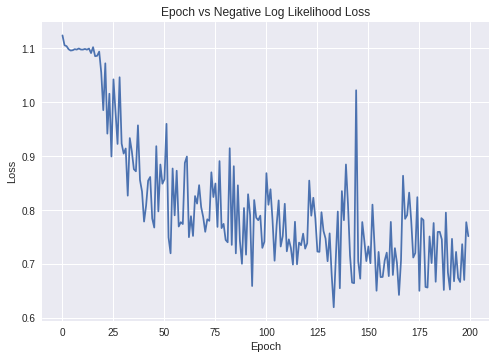

In [105]:
import matplotlib.pyplot as plt

cifar_epoch_loss_2 =  np.array(cifar_epoch_loss)
cifar_epoch_loss_2 = [i.cpu().detach().numpy().item() for i in cifar_epoch_loss_2]


x_val = np.arange(0,200)
y_val = cifar_epoch_loss_2

plt.title("Epoch vs Negative Log Likelihood Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x_val, y_val)
plt.show()